# LSTM - vanilla

In [1]:
best_model = "best_model_all_feat_2layers_all_agents.pt"

# best_model = "best_model_all_feat_all_agents.pt"

In [2]:
best_model

'best_model_all_feat_2layers_all_agents.pt'

## Load and prepare data

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [4]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
# train_data = train_data[::2]
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


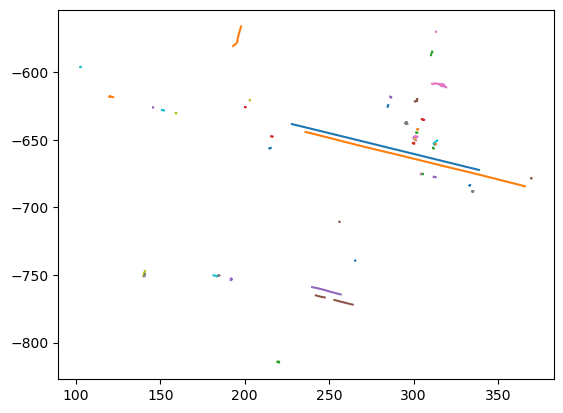

In [5]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [6]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :5].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (50, 60, 2)
        #add the feature of the scene number for each sample
       
 
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
                # future[..., 2:4] = future[..., 2:4] @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1
                # future[:, 2] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future[..., :2] = future[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale
        # hist[..., :2] = hist[..., :2] / self.scale
        # future[..., :2] = future[..., :2] / self.scale

        
        # print("hist's shape", hist.shape)
        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        # hist = hist[...,]
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale
        hist[..., :2] = hist[..., :2] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0 #why not 10

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [8]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=output_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :self.input_dim] 
       
        x = x.reshape(-1, 50, 50, self.input_dim)[:, 0, :, :]  # (B*A, 50, 5)
        # x = x.reshape(-1, 50, self.input_dim)
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, self.output_dim) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :self.output_dim].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [9]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [10]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=150, patience=15, num_agents = 1):
    """
    Improved training function with better debugging and early stopping
    """
    input_dim = model.input_dim # Historical trajectory input dimension
    output_dim = model.output_dim  # Future trajectory output dimension
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            # print(f"Batch size: {batch.x.shape}")
            pred = model(batch, forcing_ratio=forcing_ratio).view(-1, 60, output_dim)
            # y = batch.y.view(-1, 60, output_dim)
            y = batch.y.view(batch.num_graphs, 60, output_dim)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                # pred = pred.view(-1, 50, 60, output_dim)
                pred = pred.view(batch.num_graphs, 60, output_dim)
                # y = batch.y.view(-1, 50, 60, output_dim)
                # y = batch.y.view(-1, 60, output_dim)
                y = batch.y.view(batch.num_graphs, 60, 2)
                

                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()

                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                # batch_loss = criterion(pred[:, 0, :, :2], y[:, 0, :, :2]).item()
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                

                
                # pred_unnorm = pred[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                # y_unnorm = y[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

                # pred_unnorm = pred.view(-1,num_agents,60,output_dim)[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                # y_unnorm = y.view(-1,num_agents,60,output_dim)[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                pred_unnorm = pred* batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches #all agents 
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            tqdm.tqdm.write(f"Sample input first 3 steps: {sample_input[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [11]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, output_dim = 2, hidden_dim=512)
    model = model.to(device)
    num_agents = 1
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=200,
        num_agents = num_agents
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)(-1, num_agents, 60, model.output_dim)
            y = batch.y.view(-1, num_agents, 60, model.output_dim)
            
            # Unnormalize
            pred = pred[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
        
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [12]:
train_and_evaluate_model()

Epoch:   0%|          | 0/200 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_89871/1362921994.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_89871/1362921994.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   0%|          | 1/200 [00:20<1:06:51, 20.16s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 0.9629 | Val MSE 50.2377 | Val MAE 42.3243 | Val MSE 2461.6488
Sample pred first 3 steps: [[-0.00769935  0.06206309]
 [ 0.01978711  0.10633767]
 [ 0.02133254  0.06970321]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: inf -> 50.237730


Epoch:   1%|          | 2/200 [00:40<1:05:58, 19.99s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.0064 | Val MSE 32.7450 | Val MAE 25.1761 | Val MSE 1604.5053
Validation improved: 50.237730 -> 32.745004


Epoch:   2%|▏         | 3/200 [01:02<1:09:57, 21.31s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.0034 | Val MSE 15.1988 | Val MAE 19.5934 | Val MSE 744.7416
Validation improved: 32.745004 -> 15.198810


Epoch:   2%|▏         | 4/200 [01:25<1:11:14, 21.81s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.0043 | Val MSE 19.8428 | Val MAE 20.3029 | Val MSE 972.2981


Epoch:   2%|▎         | 5/200 [01:48<1:11:44, 22.07s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.0014 | Val MSE 1.8484 | Val MAE 5.9297 | Val MSE 90.5719
Validation improved: 15.198810 -> 1.848407


Epoch:   3%|▎         | 6/200 [02:10<1:12:01, 22.28s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.0023 | Val MSE 1.6124 | Val MAE 5.7449 | Val MSE 79.0094
Sample pred first 3 steps: [[-0.00557077  0.00546507]
 [-0.00313275  0.00728785]
 [ 0.00014345  0.00699236]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 1.848407 -> 1.612436


Epoch:   4%|▎         | 7/200 [02:33<1:11:56, 22.36s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.0008 | Val MSE 4.6766 | Val MAE 8.7791 | Val MSE 229.1547


Epoch:   4%|▍         | 8/200 [02:56<1:11:58, 22.49s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.0047 | Val MSE 18.1394 | Val MAE 20.5010 | Val MSE 888.8304


Epoch:   4%|▍         | 9/200 [03:18<1:11:46, 22.54s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.0016 | Val MSE 2.2061 | Val MAE 6.3373 | Val MSE 108.0975


Epoch:   5%|▌         | 10/200 [03:41<1:11:14, 22.50s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.0012 | Val MSE 6.0417 | Val MAE 11.5625 | Val MSE 296.0430


Epoch:   6%|▌         | 11/200 [04:03<1:10:40, 22.44s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.0082 | Val MSE 52.4791 | Val MAE 33.9828 | Val MSE 2571.4758
Sample pred first 3 steps: [[0.04028619 0.02184233]
 [0.00839067 0.03643164]
 [0.0329079  0.03168153]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:   6%|▌         | 12/200 [04:25<1:10:18, 22.44s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.0044 | Val MSE 1.2721 | Val MAE 5.0718 | Val MSE 62.3307
Validation improved: 1.612436 -> 1.272055


Epoch:   6%|▋         | 13/200 [04:48<1:09:55, 22.43s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.0006 | Val MSE 1.6455 | Val MAE 5.8489 | Val MSE 80.6282


Epoch:   7%|▋         | 14/200 [05:10<1:09:36, 22.46s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.0008 | Val MSE 7.2159 | Val MAE 13.1016 | Val MSE 353.5810


Epoch:   8%|▊         | 15/200 [05:33<1:09:23, 22.51s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.0023 | Val MSE 7.0164 | Val MAE 12.7478 | Val MSE 343.8045


Epoch:   8%|▊         | 16/200 [05:55<1:08:57, 22.48s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.0031 | Val MSE 5.1608 | Val MAE 9.4949 | Val MSE 252.8812
Sample pred first 3 steps: [[-0.0098896   0.00371495]
 [ 0.00680962  0.0127676 ]
 [-0.01044205  0.00868286]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:   8%|▊         | 17/200 [06:18<1:08:45, 22.54s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.0037 | Val MSE 2.2718 | Val MAE 6.0702 | Val MSE 111.3203


Epoch:   9%|▉         | 18/200 [06:41<1:08:25, 22.56s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.0043 | Val MSE 2.0538 | Val MAE 5.9638 | Val MSE 100.6356


Epoch:  10%|▉         | 19/200 [07:03<1:08:11, 22.60s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.0020 | Val MSE 1.5113 | Val MAE 5.4322 | Val MSE 74.0560


Epoch:  10%|█         | 20/200 [07:26<1:07:54, 22.63s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.0019 | Val MSE 3.4290 | Val MAE 8.8672 | Val MSE 168.0214


Epoch:  10%|█         | 21/200 [07:49<1:07:38, 22.67s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.0024 | Val MSE 26.0387 | Val MAE 24.5283 | Val MSE 1275.8962
Sample pred first 3 steps: [[ 0.00747702  0.00325099]
 [ 0.01032246 -0.00964431]
 [ 0.05075269 -0.02576987]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  11%|█         | 22/200 [08:11<1:07:09, 22.64s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.0047 | Val MSE 27.6607 | Val MAE 25.6388 | Val MSE 1355.3756


Epoch:  12%|█▏        | 23/200 [08:34<1:06:41, 22.61s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.0036 | Val MSE 10.9066 | Val MAE 15.1044 | Val MSE 534.4220


Epoch:  12%|█▏        | 24/200 [08:56<1:06:10, 22.56s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.0016 | Val MSE 1.5954 | Val MAE 5.9133 | Val MSE 78.1722


Epoch:  12%|█▎        | 25/200 [09:19<1:05:48, 22.56s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.0016 | Val MSE 7.8019 | Val MAE 11.4549 | Val MSE 382.2935


Epoch:  13%|█▎        | 26/200 [09:41<1:05:18, 22.52s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.0020 | Val MSE 1.0267 | Val MAE 4.4287 | Val MSE 50.3065
Sample pred first 3 steps: [[ 0.00388435 -0.00058893]
 [-0.00151502 -0.00583034]
 [ 0.00331945 -0.01506609]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 1.272055 -> 1.026662


Epoch:  14%|█▎        | 27/200 [10:04<1:04:46, 22.47s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.0033 | Val MSE 1.6412 | Val MAE 4.9590 | Val MSE 80.4192


Epoch:  14%|█▍        | 28/200 [10:26<1:04:35, 22.53s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.0049 | Val MSE 0.5714 | Val MAE 3.0053 | Val MSE 27.9981
Validation improved: 1.026662 -> 0.571389


Epoch:  14%|█▍        | 29/200 [10:50<1:05:11, 22.87s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.0022 | Val MSE 2.7777 | Val MAE 6.7427 | Val MSE 136.1084


Epoch:  15%|█▌        | 30/200 [11:12<1:04:25, 22.74s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.0088 | Val MSE 5.1781 | Val MAE 8.7153 | Val MSE 253.7293


Epoch:  16%|█▌        | 31/200 [11:35<1:03:52, 22.68s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.0050 | Val MSE 0.8397 | Val MAE 3.9950 | Val MSE 41.1458
Sample pred first 3 steps: [[0.0008111  0.00756697]
 [0.00510816 0.00750762]
 [0.01319803 0.01612103]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  16%|█▌        | 32/200 [11:58<1:03:31, 22.69s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.0020 | Val MSE 3.6653 | Val MAE 8.6475 | Val MSE 179.5981


Epoch:  16%|█▋        | 33/200 [12:21<1:03:39, 22.87s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.0045 | Val MSE 1.9385 | Val MAE 6.2944 | Val MSE 94.9841


Epoch:  17%|█▋        | 34/200 [12:44<1:03:05, 22.80s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.0018 | Val MSE 0.8040 | Val MAE 3.8842 | Val MSE 39.3955


Epoch:  18%|█▊        | 35/200 [13:06<1:02:25, 22.70s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.0075 | Val MSE 1.9780 | Val MAE 6.4701 | Val MSE 96.9219


Epoch:  18%|█▊        | 36/200 [13:29<1:01:58, 22.67s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.0060 | Val MSE 8.0245 | Val MAE 12.7172 | Val MSE 393.1985
Sample pred first 3 steps: [[-0.00632082 -0.00308418]
 [-0.00455899 -0.00902915]
 [-0.01180813 -0.01555039]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  18%|█▊        | 37/200 [13:51<1:01:31, 22.65s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.0096 | Val MSE 2.8167 | Val MAE 7.2965 | Val MSE 138.0195


Epoch:  19%|█▉        | 38/200 [14:14<1:00:55, 22.57s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.0062 | Val MSE 1.8719 | Val MAE 6.0897 | Val MSE 91.7241


Epoch:  20%|█▉        | 39/200 [14:37<1:01:12, 22.81s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.0132 | Val MSE 1.3744 | Val MAE 5.1637 | Val MSE 67.3465


Epoch:  20%|██        | 40/200 [15:00<1:00:40, 22.76s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.0130 | Val MSE 1.2993 | Val MAE 5.0617 | Val MSE 63.6679


Epoch:  20%|██        | 41/200 [15:22<59:55, 22.61s/epoch]  

Epoch 040 | LR 0.000855 | Train MSE 0.0243 | Val MSE 1.1215 | Val MAE 4.4922 | Val MSE 54.9536
Sample pred first 3 steps: [[-0.00045673  0.00109833]
 [-0.00284977 -0.00662438]
 [-0.01466905 -0.00992747]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  21%|██        | 42/200 [15:44<59:18, 22.52s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.0173 | Val MSE 0.9694 | Val MAE 4.3165 | Val MSE 47.5004


Epoch:  22%|██▏       | 43/200 [16:06<58:44, 22.45s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.0233 | Val MSE 0.5553 | Val MAE 2.9992 | Val MSE 27.2109
Validation improved: 0.571389 -> 0.555325


Epoch:  22%|██▏       | 44/200 [16:29<58:11, 22.38s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.0296 | Val MSE 0.5861 | Val MAE 2.9743 | Val MSE 28.7208


Epoch:  22%|██▎       | 45/200 [16:51<57:43, 22.35s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.0434 | Val MSE 0.6157 | Val MAE 3.2298 | Val MSE 30.1681


Epoch:  23%|██▎       | 46/200 [17:13<57:19, 22.34s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.0664 | Val MSE 0.8174 | Val MAE 3.7410 | Val MSE 40.0525
Sample pred first 3 steps: [[ 6.3966960e-04  1.3413094e-03]
 [-4.2123124e-03 -4.7946908e-03]
 [-1.0754928e-02  1.0367483e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  24%|██▎       | 47/200 [17:36<56:58, 22.34s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.0900 | Val MSE 0.5239 | Val MAE 2.7111 | Val MSE 25.6697
Validation improved: 0.555325 -> 0.523871


Epoch:  24%|██▍       | 48/200 [17:59<57:05, 22.54s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1659 | Val MSE 1.1201 | Val MAE 4.7755 | Val MSE 54.8849


Epoch:  24%|██▍       | 49/200 [18:22<57:31, 22.86s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.2281 | Val MSE 0.5557 | Val MAE 2.8411 | Val MSE 27.2297


Epoch:  25%|██▌       | 50/200 [18:45<56:57, 22.79s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.4238 | Val MSE 0.5285 | Val MAE 2.8233 | Val MSE 25.8955


Epoch:  26%|██▌       | 51/200 [19:08<56:32, 22.77s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.6325 | Val MSE 0.7227 | Val MAE 3.1696 | Val MSE 35.4135
Sample pred first 3 steps: [[ 0.00249793 -0.00263767]
 [ 0.00810826  0.00941638]
 [-0.00429392 -0.0127654 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  26%|██▌       | 52/200 [19:32<57:34, 23.34s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.5412 | Val MSE 0.4391 | Val MAE 2.4562 | Val MSE 21.5174
Validation improved: 0.523871 -> 0.439130


Epoch:  26%|██▋       | 53/200 [19:58<58:44, 23.98s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.4762 | Val MSE 0.5574 | Val MAE 3.1370 | Val MSE 27.3118


Epoch:  27%|██▋       | 54/200 [20:22<58:49, 24.18s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.4586 | Val MSE 0.5025 | Val MAE 2.9276 | Val MSE 24.6225


Epoch:  28%|██▊       | 55/200 [20:47<58:57, 24.40s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.4368 | Val MSE 0.5167 | Val MAE 2.9978 | Val MSE 25.3162


Epoch:  28%|██▊       | 56/200 [21:12<58:25, 24.34s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.4325 | Val MSE 0.5009 | Val MAE 2.9521 | Val MSE 24.5428
Sample pred first 3 steps: [[-0.0090854  -0.0041841 ]
 [ 0.01465036 -0.00853419]
 [-0.00500941  0.02011176]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  28%|██▊       | 57/200 [21:36<58:22, 24.50s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.4256 | Val MSE 0.3897 | Val MAE 2.2241 | Val MSE 19.0932
Validation improved: 0.439130 -> 0.389657


Epoch:  29%|██▉       | 58/200 [22:01<58:06, 24.55s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.3951 | Val MSE 0.3772 | Val MAE 2.3953 | Val MSE 18.4845
Validation improved: 0.389657 -> 0.377235


Epoch:  30%|██▉       | 59/200 [22:26<57:40, 24.54s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.3935 | Val MSE 0.3615 | Val MAE 2.2345 | Val MSE 17.7133
Validation improved: 0.377235 -> 0.361496


Epoch:  30%|███       | 60/200 [22:50<57:26, 24.62s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.3676 | Val MSE 0.3248 | Val MAE 2.0340 | Val MSE 15.9169
Validation improved: 0.361496 -> 0.324834


Epoch:  30%|███       | 61/200 [23:15<57:07, 24.66s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.3514 | Val MSE 0.3624 | Val MAE 2.4536 | Val MSE 17.7598
Sample pred first 3 steps: [[0.00856196 0.0165482 ]
 [0.01470356 0.00304718]
 [0.02448671 0.00283636]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  31%|███       | 62/200 [23:40<56:52, 24.72s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.3387 | Val MSE 0.3026 | Val MAE 2.0143 | Val MSE 14.8258
Validation improved: 0.324834 -> 0.302567


Epoch:  32%|███▏      | 63/200 [24:05<56:22, 24.69s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.3291 | Val MSE 0.2963 | Val MAE 1.8931 | Val MSE 14.5200
Validation improved: 0.302567 -> 0.296328


Epoch:  32%|███▏      | 64/200 [24:30<56:19, 24.85s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.3164 | Val MSE 0.2874 | Val MAE 1.9219 | Val MSE 14.0807
Validation improved: 0.296328 -> 0.287362


Epoch:  32%|███▎      | 65/200 [24:55<55:51, 24.82s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.3054 | Val MSE 0.2682 | Val MAE 1.7686 | Val MSE 13.1394
Validation improved: 0.287362 -> 0.268152


Epoch:  33%|███▎      | 66/200 [25:19<55:22, 24.80s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.3003 | Val MSE 0.2785 | Val MAE 1.8734 | Val MSE 13.6463
Sample pred first 3 steps: [[-0.00846578  0.0092064 ]
 [ 0.01227872 -0.00022174]
 [ 0.0306152  -0.00226919]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  34%|███▎      | 67/200 [25:44<54:55, 24.78s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.2950 | Val MSE 0.2600 | Val MAE 1.8026 | Val MSE 12.7419
Validation improved: 0.268152 -> 0.260040


Epoch:  34%|███▍      | 68/200 [26:09<54:36, 24.82s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.2908 | Val MSE 0.2715 | Val MAE 1.9248 | Val MSE 13.3049


Epoch:  34%|███▍      | 69/200 [26:34<54:10, 24.81s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.2857 | Val MSE 0.2524 | Val MAE 1.6868 | Val MSE 12.3667
Validation improved: 0.260040 -> 0.252383


Epoch:  35%|███▌      | 70/200 [26:58<53:41, 24.78s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.2835 | Val MSE 0.2685 | Val MAE 1.8738 | Val MSE 13.1569


Epoch:  36%|███▌      | 71/200 [27:23<53:14, 24.77s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.2793 | Val MSE 0.2580 | Val MAE 1.8684 | Val MSE 12.6436
Sample pred first 3 steps: [[-0.00228658 -0.00554489]
 [ 0.03055242 -0.00449575]
 [ 0.01746101 -0.01028374]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  36%|███▌      | 72/200 [27:48<52:53, 24.79s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.2701 | Val MSE 0.2489 | Val MAE 1.7862 | Val MSE 12.1946
Validation improved: 0.252383 -> 0.248870


Epoch:  36%|███▋      | 73/200 [28:13<52:26, 24.78s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.2715 | Val MSE 0.2426 | Val MAE 1.6723 | Val MSE 11.8897
Validation improved: 0.248870 -> 0.242646


Epoch:  37%|███▋      | 74/200 [28:37<51:51, 24.69s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.2687 | Val MSE 0.2533 | Val MAE 1.7348 | Val MSE 12.4128


Epoch:  38%|███▊      | 75/200 [29:02<51:22, 24.66s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.2639 | Val MSE 0.2466 | Val MAE 1.7585 | Val MSE 12.0842


Epoch:  38%|███▊      | 76/200 [29:27<51:00, 24.68s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.2602 | Val MSE 0.2378 | Val MAE 1.6820 | Val MSE 11.6519
Sample pred first 3 steps: [[-0.01464847 -0.00864322]
 [ 0.00643008 -0.00179116]
 [-0.01248137  0.00336919]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.242646 -> 0.237794


Epoch:  38%|███▊      | 77/200 [29:51<50:31, 24.65s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.2584 | Val MSE 0.2551 | Val MAE 1.8035 | Val MSE 12.5003


Epoch:  39%|███▉      | 78/200 [30:16<50:04, 24.62s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.2583 | Val MSE 0.2371 | Val MAE 1.7225 | Val MSE 11.6179
Validation improved: 0.237794 -> 0.237100


Epoch:  40%|███▉      | 79/200 [30:40<49:35, 24.59s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.2587 | Val MSE 0.2414 | Val MAE 1.6999 | Val MSE 11.8301


Epoch:  40%|████      | 80/200 [31:05<49:15, 24.63s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.2549 | Val MSE 0.2390 | Val MAE 1.7254 | Val MSE 11.7088


Epoch:  40%|████      | 81/200 [31:29<48:46, 24.59s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.2510 | Val MSE 0.2431 | Val MAE 1.8255 | Val MSE 11.9139
Sample pred first 3 steps: [[ 0.01331344  0.00618025]
 [ 0.01979939 -0.00450522]
 [ 0.01414759 -0.01237075]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  41%|████      | 82/200 [31:54<48:27, 24.64s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.2497 | Val MSE 0.2283 | Val MAE 1.6284 | Val MSE 11.1856
Validation improved: 0.237100 -> 0.228278


Epoch:  42%|████▏     | 83/200 [32:19<48:03, 24.64s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.2420 | Val MSE 0.2390 | Val MAE 1.7447 | Val MSE 11.7095


Epoch:  42%|████▏     | 84/200 [32:44<47:43, 24.68s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.2428 | Val MSE 0.2256 | Val MAE 1.6550 | Val MSE 11.0524
Validation improved: 0.228278 -> 0.225559


Epoch:  42%|████▎     | 85/200 [33:08<47:18, 24.68s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.2395 | Val MSE 0.2287 | Val MAE 1.6210 | Val MSE 11.2074


Epoch:  43%|████▎     | 86/200 [33:33<46:45, 24.61s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.2382 | Val MSE 0.2229 | Val MAE 1.6136 | Val MSE 10.9205
Sample pred first 3 steps: [[-0.00330582 -0.00314094]
 [ 0.01393091 -0.00046915]
 [ 0.00599497 -0.01008461]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.225559 -> 0.222868


Epoch:  44%|████▎     | 87/200 [33:57<46:22, 24.63s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.2389 | Val MSE 0.2343 | Val MAE 1.7655 | Val MSE 11.4794


Epoch:  44%|████▍     | 88/200 [34:22<46:03, 24.67s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.2363 | Val MSE 0.2166 | Val MAE 1.6130 | Val MSE 10.6121
Validation improved: 0.222868 -> 0.216573


Epoch:  44%|████▍     | 89/200 [34:47<45:32, 24.61s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.2360 | Val MSE 0.2185 | Val MAE 1.6377 | Val MSE 10.7081


Epoch:  45%|████▌     | 90/200 [35:11<45:02, 24.57s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.2306 | Val MSE 0.2187 | Val MAE 1.6068 | Val MSE 10.7148


Epoch:  46%|████▌     | 91/200 [35:36<44:42, 24.61s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.2317 | Val MSE 0.2152 | Val MAE 1.5813 | Val MSE 10.5471
Sample pred first 3 steps: [[-0.00073727  0.00189263]
 [ 0.00986952  0.00068096]
 [-0.00173526 -0.00766168]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.216573 -> 0.215247


Epoch:  46%|████▌     | 92/200 [36:01<44:25, 24.68s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.2316 | Val MSE 0.2159 | Val MAE 1.6057 | Val MSE 10.5775


Epoch:  46%|████▋     | 93/200 [36:25<43:58, 24.66s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.2293 | Val MSE 0.2141 | Val MAE 1.5626 | Val MSE 10.4890
Validation improved: 0.215247 -> 0.214061


Epoch:  47%|████▋     | 94/200 [36:50<43:31, 24.64s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.2286 | Val MSE 0.2167 | Val MAE 1.6275 | Val MSE 10.6168


Epoch:  48%|████▊     | 95/200 [37:15<43:06, 24.64s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.2282 | Val MSE 0.2143 | Val MAE 1.6180 | Val MSE 10.5012


Epoch:  48%|████▊     | 96/200 [37:39<42:44, 24.66s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.2261 | Val MSE 0.2287 | Val MAE 1.7771 | Val MSE 11.2075
Sample pred first 3 steps: [[-0.00026517  0.00016007]
 [ 0.00074933  0.0085851 ]
 [-0.01114748  0.01389182]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  48%|████▊     | 97/200 [38:04<42:18, 24.64s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.2257 | Val MSE 0.2125 | Val MAE 1.6113 | Val MSE 10.4141
Validation improved: 0.214061 -> 0.212533


Epoch:  49%|████▉     | 98/200 [38:28<41:48, 24.59s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.2242 | Val MSE 0.2100 | Val MAE 1.5515 | Val MSE 10.2921
Validation improved: 0.212533 -> 0.210044


Epoch:  50%|████▉     | 99/200 [38:53<41:25, 24.61s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.2223 | Val MSE 0.2067 | Val MAE 1.5619 | Val MSE 10.1261
Validation improved: 0.210044 -> 0.206655


Epoch:  50%|█████     | 100/200 [39:18<41:05, 24.66s/epoch]

Epoch 099 | LR 0.000041 | Train MSE 0.2220 | Val MSE 0.2046 | Val MAE 1.5158 | Val MSE 10.0275
Validation improved: 0.206655 -> 0.204642


Epoch:  50%|█████     | 101/200 [39:42<40:38, 24.63s/epoch]

Epoch 100 | LR 0.000039 | Train MSE 0.2187 | Val MSE 0.2064 | Val MAE 1.4899 | Val MSE 10.1149
Sample pred first 3 steps: [[ 0.00090579  0.00331257]
 [ 0.00730554  0.00216396]
 [-0.00449898 -0.00724061]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  51%|█████     | 102/200 [40:07<40:12, 24.62s/epoch]

Epoch 101 | LR 0.000037 | Train MSE 0.2180 | Val MSE 0.2084 | Val MAE 1.5444 | Val MSE 10.2120


Epoch:  52%|█████▏    | 103/200 [40:31<39:41, 24.56s/epoch]

Epoch 102 | LR 0.000036 | Train MSE 0.2185 | Val MSE 0.2039 | Val MAE 1.5066 | Val MSE 9.9933
Validation improved: 0.204642 -> 0.203944


Epoch:  52%|█████▏    | 104/200 [40:56<39:18, 24.57s/epoch]

Epoch 103 | LR 0.000034 | Train MSE 0.2168 | Val MSE 0.2070 | Val MAE 1.5351 | Val MSE 10.1420


Epoch:  52%|█████▎    | 105/200 [41:20<38:51, 24.55s/epoch]

Epoch 104 | LR 0.000032 | Train MSE 0.2181 | Val MSE 0.2026 | Val MAE 1.5301 | Val MSE 9.9273
Validation improved: 0.203944 -> 0.202598


Epoch:  53%|█████▎    | 106/200 [41:45<38:24, 24.52s/epoch]

Epoch 105 | LR 0.000030 | Train MSE 0.2184 | Val MSE 0.2061 | Val MAE 1.5290 | Val MSE 10.0980
Sample pred first 3 steps: [[ 0.00142281 -0.00195016]
 [ 0.00766365  0.00172123]
 [ 0.00281321 -0.00385641]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  54%|█████▎    | 107/200 [42:09<38:02, 24.55s/epoch]

Epoch 106 | LR 0.000029 | Train MSE 0.2169 | Val MSE 0.2058 | Val MAE 1.5604 | Val MSE 10.0826


Epoch:  54%|█████▍    | 108/200 [42:34<37:48, 24.65s/epoch]

Epoch 107 | LR 0.000027 | Train MSE 0.2173 | Val MSE 0.2020 | Val MAE 1.5349 | Val MSE 9.9002
Validation improved: 0.202598 -> 0.202045


Epoch:  55%|█████▍    | 109/200 [42:59<37:20, 24.62s/epoch]

Epoch 108 | LR 0.000026 | Train MSE 0.2159 | Val MSE 0.2047 | Val MAE 1.5125 | Val MSE 10.0307


Epoch:  55%|█████▌    | 110/200 [43:24<36:57, 24.64s/epoch]

Epoch 109 | LR 0.000025 | Train MSE 0.2144 | Val MSE 0.2023 | Val MAE 1.5095 | Val MSE 9.9138


Epoch:  56%|█████▌    | 111/200 [43:48<36:35, 24.67s/epoch]

Epoch 110 | LR 0.000024 | Train MSE 0.2123 | Val MSE 0.2023 | Val MAE 1.4906 | Val MSE 9.9146
Sample pred first 3 steps: [[ 0.00156643 -0.00109103]
 [ 0.00256448  0.0029045 ]
 [-0.0040674  -0.00235859]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  56%|█████▌    | 112/200 [44:13<36:15, 24.72s/epoch]

Epoch 111 | LR 0.000022 | Train MSE 0.2133 | Val MSE 0.2026 | Val MAE 1.5269 | Val MSE 9.9286


Epoch:  56%|█████▋    | 113/200 [44:38<35:54, 24.76s/epoch]

Epoch 112 | LR 0.000021 | Train MSE 0.2135 | Val MSE 0.1995 | Val MAE 1.4744 | Val MSE 9.7767
Validation improved: 0.202045 -> 0.199524


Epoch:  57%|█████▋    | 114/200 [45:03<35:24, 24.70s/epoch]

Epoch 113 | LR 0.000020 | Train MSE 0.2115 | Val MSE 0.2034 | Val MAE 1.5525 | Val MSE 9.9689


Epoch:  57%|█████▊    | 115/200 [45:27<34:54, 24.64s/epoch]

Epoch 114 | LR 0.000019 | Train MSE 0.2128 | Val MSE 0.2024 | Val MAE 1.4844 | Val MSE 9.9170


Epoch:  58%|█████▊    | 116/200 [45:52<34:36, 24.72s/epoch]

Epoch 115 | LR 0.000018 | Train MSE 0.2103 | Val MSE 0.1988 | Val MAE 1.4828 | Val MSE 9.7435
Sample pred first 3 steps: [[ 0.00422458 -0.00289841]
 [ 0.00607551  0.00470005]
 [-0.00311437 -0.0029947 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.199524 -> 0.198848


Epoch:  58%|█████▊    | 117/200 [46:16<34:02, 24.61s/epoch]

Epoch 116 | LR 0.000017 | Train MSE 0.2114 | Val MSE 0.2009 | Val MAE 1.4916 | Val MSE 9.8435


Epoch:  59%|█████▉    | 118/200 [46:41<33:40, 24.64s/epoch]

Epoch 117 | LR 0.000016 | Train MSE 0.2117 | Val MSE 0.1977 | Val MAE 1.4813 | Val MSE 9.6893
Validation improved: 0.198848 -> 0.197742


Epoch:  60%|█████▉    | 119/200 [47:06<33:15, 24.64s/epoch]

Epoch 118 | LR 0.000016 | Train MSE 0.2100 | Val MSE 0.1974 | Val MAE 1.4636 | Val MSE 9.6718
Validation improved: 0.197742 -> 0.197385


Epoch:  60%|██████    | 120/200 [47:30<32:50, 24.63s/epoch]

Epoch 119 | LR 0.000015 | Train MSE 0.2079 | Val MSE 0.2009 | Val MAE 1.4781 | Val MSE 9.8452


Epoch:  60%|██████    | 121/200 [47:55<32:18, 24.54s/epoch]

Epoch 120 | LR 0.000014 | Train MSE 0.2096 | Val MSE 0.1980 | Val MAE 1.4671 | Val MSE 9.7020
Sample pred first 3 steps: [[ 2.0690039e-03  8.1185251e-05]
 [ 2.5578663e-03  3.6371090e-03]
 [-3.8638189e-03 -4.7381781e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  61%|██████    | 122/200 [48:19<31:59, 24.61s/epoch]

Epoch 121 | LR 0.000013 | Train MSE 0.2073 | Val MSE 0.1987 | Val MAE 1.4668 | Val MSE 9.7360


Epoch:  62%|██████▏   | 123/200 [48:44<31:32, 24.58s/epoch]

Epoch 122 | LR 0.000013 | Train MSE 0.2083 | Val MSE 0.1972 | Val MAE 1.4716 | Val MSE 9.6610
Validation improved: 0.197385 -> 0.197164


Epoch:  62%|██████▏   | 124/200 [49:09<31:13, 24.65s/epoch]

Epoch 123 | LR 0.000012 | Train MSE 0.2078 | Val MSE 0.1992 | Val MAE 1.4908 | Val MSE 9.7623


Epoch:  62%|██████▎   | 125/200 [49:33<30:49, 24.67s/epoch]

Epoch 124 | LR 0.000011 | Train MSE 0.2091 | Val MSE 0.1986 | Val MAE 1.4801 | Val MSE 9.7332


Epoch:  63%|██████▎   | 126/200 [49:58<30:24, 24.65s/epoch]

Epoch 125 | LR 0.000011 | Train MSE 0.2085 | Val MSE 0.1986 | Val MAE 1.4846 | Val MSE 9.7331
Sample pred first 3 steps: [[ 0.00143807 -0.00096899]
 [ 0.00262835  0.00642873]
 [-0.00535885  0.00236099]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  64%|██████▎   | 127/200 [50:23<30:05, 24.73s/epoch]

Epoch 126 | LR 0.000010 | Train MSE 0.2102 | Val MSE 0.1965 | Val MAE 1.4701 | Val MSE 9.6303
Validation improved: 0.197164 -> 0.196538


Epoch:  64%|██████▍   | 128/200 [50:48<29:56, 24.95s/epoch]

Epoch 127 | LR 0.000010 | Train MSE 0.2083 | Val MSE 0.1990 | Val MAE 1.4759 | Val MSE 9.7501


Epoch:  64%|██████▍   | 129/200 [51:15<29:56, 25.30s/epoch]

Epoch 128 | LR 0.000009 | Train MSE 0.2086 | Val MSE 0.1988 | Val MAE 1.4764 | Val MSE 9.7401


Epoch:  65%|██████▌   | 130/200 [51:41<29:55, 25.65s/epoch]

Epoch 129 | LR 0.000009 | Train MSE 0.2103 | Val MSE 0.1978 | Val MAE 1.4578 | Val MSE 9.6899


Epoch:  66%|██████▌   | 131/200 [52:07<29:36, 25.75s/epoch]

Epoch 130 | LR 0.000008 | Train MSE 0.2068 | Val MSE 0.1970 | Val MAE 1.4691 | Val MSE 9.6551
Sample pred first 3 steps: [[ 0.00311125 -0.0001344 ]
 [ 0.00312706  0.00361162]
 [-0.0052822  -0.00147561]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  66%|██████▌   | 132/200 [52:32<29:02, 25.62s/epoch]

Epoch 131 | LR 0.000008 | Train MSE 0.2085 | Val MSE 0.1953 | Val MAE 1.4404 | Val MSE 9.5708
Validation improved: 0.196538 -> 0.195324


Epoch:  66%|██████▋   | 133/200 [52:58<28:28, 25.51s/epoch]

Epoch 132 | LR 0.000008 | Train MSE 0.2072 | Val MSE 0.1965 | Val MAE 1.4495 | Val MSE 9.6286


Epoch:  67%|██████▋   | 134/200 [53:23<28:09, 25.59s/epoch]

Epoch 133 | LR 0.000007 | Train MSE 0.2090 | Val MSE 0.1984 | Val MAE 1.4862 | Val MSE 9.7230


Epoch:  68%|██████▊   | 135/200 [53:49<27:42, 25.58s/epoch]

Epoch 134 | LR 0.000007 | Train MSE 0.2063 | Val MSE 0.1972 | Val MAE 1.4998 | Val MSE 9.6641


Epoch:  68%|██████▊   | 136/200 [54:15<27:21, 25.65s/epoch]

Epoch 135 | LR 0.000007 | Train MSE 0.2062 | Val MSE 0.1980 | Val MAE 1.4723 | Val MSE 9.7026
Sample pred first 3 steps: [[ 0.00053339  0.00197209]
 [ 0.00285404  0.00614338]
 [-0.0069683  -0.0016219 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  68%|██████▊   | 137/200 [54:40<26:44, 25.47s/epoch]

Epoch 136 | LR 0.000006 | Train MSE 0.2071 | Val MSE 0.1956 | Val MAE 1.4507 | Val MSE 9.5841


Epoch:  69%|██████▉   | 138/200 [55:06<26:29, 25.64s/epoch]

Epoch 137 | LR 0.000006 | Train MSE 0.2063 | Val MSE 0.1982 | Val MAE 1.4531 | Val MSE 9.7094


Epoch:  70%|██████▉   | 139/200 [55:32<26:04, 25.65s/epoch]

Epoch 138 | LR 0.000006 | Train MSE 0.2040 | Val MSE 0.1952 | Val MAE 1.4492 | Val MSE 9.5635
Validation improved: 0.195324 -> 0.195173


Epoch:  70%|███████   | 140/200 [55:58<25:50, 25.84s/epoch]

Epoch 139 | LR 0.000005 | Train MSE 0.2082 | Val MSE 0.1960 | Val MAE 1.4631 | Val MSE 9.6025


Epoch:  70%|███████   | 141/200 [56:24<25:37, 26.06s/epoch]

Epoch 140 | LR 0.000005 | Train MSE 0.2058 | Val MSE 0.1961 | Val MAE 1.4521 | Val MSE 9.6093
Sample pred first 3 steps: [[ 3.3596009e-03  9.7256154e-05]
 [ 5.6617409e-03  5.0690286e-03]
 [-3.6884993e-03  1.9678101e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  71%|███████   | 142/200 [56:50<25:03, 25.93s/epoch]

Epoch 141 | LR 0.000005 | Train MSE 0.2056 | Val MSE 0.1955 | Val MAE 1.4527 | Val MSE 9.5775


Epoch:  72%|███████▏  | 143/200 [57:16<24:37, 25.93s/epoch]

Epoch 142 | LR 0.000005 | Train MSE 0.2045 | Val MSE 0.1959 | Val MAE 1.4556 | Val MSE 9.5999


Epoch:  72%|███████▏  | 144/200 [57:41<24:03, 25.77s/epoch]

Epoch 143 | LR 0.000004 | Train MSE 0.2062 | Val MSE 0.1951 | Val MAE 1.4566 | Val MSE 9.5595
Validation improved: 0.195173 -> 0.195093


Epoch:  72%|███████▎  | 145/200 [58:06<23:12, 25.32s/epoch]

Epoch 144 | LR 0.000004 | Train MSE 0.2059 | Val MSE 0.1954 | Val MAE 1.4443 | Val MSE 9.5742


Epoch:  73%|███████▎  | 146/200 [58:31<22:41, 25.21s/epoch]

Epoch 145 | LR 0.000004 | Train MSE 0.2056 | Val MSE 0.1951 | Val MAE 1.4668 | Val MSE 9.5579
Sample pred first 3 steps: [[ 1.5755221e-03 -9.4786286e-05]
 [ 4.2249039e-03  4.2509884e-03]
 [-3.4647807e-03  1.5659481e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.195093 -> 0.195059


Epoch:  74%|███████▎  | 147/200 [58:59<23:01, 26.07s/epoch]

Epoch 146 | LR 0.000004 | Train MSE 0.2057 | Val MSE 0.1951 | Val MAE 1.4597 | Val MSE 9.5617


Epoch:  74%|███████▍  | 148/200 [59:24<22:32, 26.00s/epoch]

Epoch 147 | LR 0.000004 | Train MSE 0.2063 | Val MSE 0.1966 | Val MAE 1.4619 | Val MSE 9.6322


Epoch:  74%|███████▍  | 149/200 [59:50<22:02, 25.93s/epoch]

Epoch 148 | LR 0.000003 | Train MSE 0.2066 | Val MSE 0.1954 | Val MAE 1.4592 | Val MSE 9.5727


Epoch:  75%|███████▌  | 150/200 [1:00:18<21:57, 26.35s/epoch]

Epoch 149 | LR 0.000003 | Train MSE 0.2055 | Val MSE 0.1951 | Val MAE 1.4448 | Val MSE 9.5610


Epoch:  76%|███████▌  | 151/200 [1:00:43<21:23, 26.19s/epoch]

Epoch 150 | LR 0.000003 | Train MSE 0.2050 | Val MSE 0.1951 | Val MAE 1.4479 | Val MSE 9.5577
Sample pred first 3 steps: [[ 0.00201183  0.00054549]
 [ 0.00471794  0.0040586 ]
 [-0.00458879 -0.00109744]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.195059 -> 0.195055


Epoch:  76%|███████▌  | 152/200 [1:01:08<20:34, 25.71s/epoch]

Epoch 151 | LR 0.000003 | Train MSE 0.2052 | Val MSE 0.1944 | Val MAE 1.4436 | Val MSE 9.5278
Validation improved: 0.195055 -> 0.194444


Epoch:  76%|███████▋  | 153/200 [1:01:33<19:56, 25.45s/epoch]

Epoch 152 | LR 0.000003 | Train MSE 0.2061 | Val MSE 0.1963 | Val MAE 1.4569 | Val MSE 9.6199


Epoch:  77%|███████▋  | 154/200 [1:01:58<19:21, 25.25s/epoch]

Epoch 153 | LR 0.000003 | Train MSE 0.2059 | Val MSE 0.1957 | Val MAE 1.4499 | Val MSE 9.5868


Epoch:  78%|███████▊  | 155/200 [1:02:23<18:57, 25.28s/epoch]

Epoch 154 | LR 0.000002 | Train MSE 0.2042 | Val MSE 0.1963 | Val MAE 1.4671 | Val MSE 9.6190


Epoch:  78%|███████▊  | 156/200 [1:02:48<18:35, 25.34s/epoch]

Epoch 155 | LR 0.000002 | Train MSE 0.2037 | Val MSE 0.1946 | Val MAE 1.4526 | Val MSE 9.5358
Sample pred first 3 steps: [[ 2.4551004e-03  7.9646707e-06]
 [ 5.5450052e-03  3.8748458e-03]
 [-2.0264238e-03 -1.7462745e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  78%|███████▊  | 157/200 [1:03:14<18:08, 25.31s/epoch]

Epoch 156 | LR 0.000002 | Train MSE 0.2045 | Val MSE 0.1965 | Val MAE 1.4653 | Val MSE 9.6302


Epoch:  79%|███████▉  | 158/200 [1:03:38<17:35, 25.14s/epoch]

Epoch 157 | LR 0.000002 | Train MSE 0.2051 | Val MSE 0.1942 | Val MAE 1.4476 | Val MSE 9.5151
Validation improved: 0.194444 -> 0.194187


Epoch:  80%|███████▉  | 159/200 [1:04:03<17:05, 25.01s/epoch]

Epoch 158 | LR 0.000002 | Train MSE 0.2044 | Val MSE 0.1950 | Val MAE 1.4526 | Val MSE 9.5546


Epoch:  80%|████████  | 160/200 [1:04:29<16:52, 25.31s/epoch]

Epoch 159 | LR 0.000002 | Train MSE 0.2028 | Val MSE 0.1954 | Val MAE 1.4491 | Val MSE 9.5746


Epoch:  80%|████████  | 161/200 [1:04:55<16:31, 25.43s/epoch]

Epoch 160 | LR 0.000002 | Train MSE 0.2058 | Val MSE 0.1955 | Val MAE 1.4684 | Val MSE 9.5808
Sample pred first 3 steps: [[ 0.00145316  0.00079044]
 [ 0.00325221  0.0046561 ]
 [-0.00422734  0.00219502]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  81%|████████  | 162/200 [1:05:21<16:18, 25.74s/epoch]

Epoch 161 | LR 0.000002 | Train MSE 0.2024 | Val MSE 0.1949 | Val MAE 1.4469 | Val MSE 9.5521


Epoch:  82%|████████▏ | 163/200 [1:05:47<15:57, 25.87s/epoch]

Epoch 162 | LR 0.000002 | Train MSE 0.2041 | Val MSE 0.1954 | Val MAE 1.4465 | Val MSE 9.5738


Epoch:  82%|████████▏ | 164/200 [1:06:13<15:32, 25.90s/epoch]

Epoch 163 | LR 0.000002 | Train MSE 0.2043 | Val MSE 0.1944 | Val MAE 1.4518 | Val MSE 9.5270


Epoch:  82%|████████▎ | 165/200 [1:06:41<15:25, 26.44s/epoch]

Epoch 164 | LR 0.000001 | Train MSE 0.2041 | Val MSE 0.1948 | Val MAE 1.4504 | Val MSE 9.5449


Epoch:  83%|████████▎ | 166/200 [1:07:06<14:43, 25.98s/epoch]

Epoch 165 | LR 0.000001 | Train MSE 0.2039 | Val MSE 0.1942 | Val MAE 1.4392 | Val MSE 9.5143
Sample pred first 3 steps: [[ 0.00169224  0.00033005]
 [ 0.00527816  0.00355639]
 [-0.00274751 -0.00173976]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: 0.194187 -> 0.194169


Epoch:  84%|████████▎ | 167/200 [1:07:33<14:23, 26.17s/epoch]

Epoch 166 | LR 0.000001 | Train MSE 0.2059 | Val MSE 0.1954 | Val MAE 1.4496 | Val MSE 9.5753


Epoch:  84%|████████▍ | 168/200 [1:08:00<14:10, 26.59s/epoch]

Epoch 167 | LR 0.000001 | Train MSE 0.2037 | Val MSE 0.1952 | Val MAE 1.4532 | Val MSE 9.5641


Epoch:  84%|████████▍ | 169/200 [1:08:26<13:38, 26.39s/epoch]

Epoch 168 | LR 0.000001 | Train MSE 0.2033 | Val MSE 0.1949 | Val MAE 1.4444 | Val MSE 9.5497


Epoch:  85%|████████▌ | 170/200 [1:08:52<13:08, 26.29s/epoch]

Epoch 169 | LR 0.000001 | Train MSE 0.2026 | Val MSE 0.1948 | Val MAE 1.4478 | Val MSE 9.5473


Epoch:  86%|████████▌ | 171/200 [1:09:22<13:14, 27.40s/epoch]

Epoch 170 | LR 0.000001 | Train MSE 0.2048 | Val MSE 0.1950 | Val MAE 1.4457 | Val MSE 9.5559
Sample pred first 3 steps: [[ 0.00144986  0.00021341]
 [ 0.00462183  0.0032933 ]
 [-0.00282682 -0.00136811]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  86%|████████▌ | 172/200 [1:09:47<12:25, 26.61s/epoch]

Epoch 171 | LR 0.000001 | Train MSE 0.2042 | Val MSE 0.1956 | Val MAE 1.4502 | Val MSE 9.5825


Epoch:  86%|████████▋ | 173/200 [1:10:12<11:43, 26.05s/epoch]

Epoch 172 | LR 0.000001 | Train MSE 0.2050 | Val MSE 0.1949 | Val MAE 1.4506 | Val MSE 9.5524


Epoch:  87%|████████▋ | 174/200 [1:10:36<11:04, 25.55s/epoch]

Epoch 173 | LR 0.000001 | Train MSE 0.2033 | Val MSE 0.1949 | Val MAE 1.4461 | Val MSE 9.5497


Epoch:  88%|████████▊ | 175/200 [1:11:01<10:34, 25.38s/epoch]

Epoch 174 | LR 0.000001 | Train MSE 0.2037 | Val MSE 0.1947 | Val MAE 1.4455 | Val MSE 9.5398


Epoch:  88%|████████▊ | 176/200 [1:11:27<10:09, 25.41s/epoch]

Epoch 175 | LR 0.000001 | Train MSE 0.2033 | Val MSE 0.1945 | Val MAE 1.4399 | Val MSE 9.5324
Sample pred first 3 steps: [[ 0.00167502  0.00031387]
 [ 0.00487845  0.00358375]
 [-0.00264652 -0.00153111]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  88%|████████▊ | 177/200 [1:11:52<09:43, 25.39s/epoch]

Epoch 176 | LR 0.000001 | Train MSE 0.2049 | Val MSE 0.1948 | Val MAE 1.4481 | Val MSE 9.5443


Epoch:  89%|████████▉ | 178/200 [1:12:17<09:16, 25.28s/epoch]

Epoch 177 | LR 0.000001 | Train MSE 0.2048 | Val MSE 0.1949 | Val MAE 1.4455 | Val MSE 9.5480


Epoch:  90%|████████▉ | 179/200 [1:12:43<08:53, 25.42s/epoch]

Epoch 178 | LR 0.000001 | Train MSE 0.2039 | Val MSE 0.1951 | Val MAE 1.4474 | Val MSE 9.5615


Epoch:  90%|█████████ | 180/200 [1:13:09<08:35, 25.77s/epoch]

Epoch 179 | LR 0.000001 | Train MSE 0.2037 | Val MSE 0.1950 | Val MAE 1.4424 | Val MSE 9.5557


Epoch:  90%|█████████ | 181/200 [1:13:35<08:10, 25.79s/epoch]

Epoch 180 | LR 0.000001 | Train MSE 0.2031 | Val MSE 0.1951 | Val MAE 1.4473 | Val MSE 9.5580
Sample pred first 3 steps: [[ 1.9001886e-03  7.4643642e-05]
 [ 5.0743893e-03  3.9541610e-03]
 [-2.8178915e-03 -1.2448989e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:  91%|█████████ | 182/200 [1:14:02<07:48, 26.03s/epoch]

Epoch 181 | LR 0.000001 | Train MSE 0.2041 | Val MSE 0.1951 | Val MAE 1.4463 | Val MSE 9.5584


Epoch:  92%|█████████▏| 183/200 [1:14:28<07:24, 26.13s/epoch]

Epoch 182 | LR 0.000001 | Train MSE 0.2033 | Val MSE 0.1949 | Val MAE 1.4433 | Val MSE 9.5517


Epoch:  92%|█████████▏| 184/200 [1:14:57<07:13, 27.07s/epoch]

Epoch 183 | LR 0.000001 | Train MSE 0.2037 | Val MSE 0.1949 | Val MAE 1.4456 | Val MSE 9.5517


Epoch:  92%|█████████▎| 185/200 [1:15:26<06:51, 27.45s/epoch]

Epoch 184 | LR 0.000001 | Train MSE 0.2037 | Val MSE 0.1947 | Val MAE 1.4469 | Val MSE 9.5415


Epoch:  92%|█████████▎| 185/200 [1:15:51<06:09, 24.60s/epoch]


Epoch 185 | LR 0.000001 | Train MSE 0.2040 | Val MSE 0.1950 | Val MAE 1.4426 | Val MSE 9.5534
Sample pred first 3 steps: [[ 0.00198031 -0.00010427]
 [ 0.00469074  0.00404942]
 [-0.00298768 -0.00083145]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Early stopping after 186 epochs without improvement


TypeError: 'Tensor' object is not callable

# Final Pred

In [68]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, hidden_dim=512).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm[...,:2] * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_5_out.csv', index=True)

In [69]:
output_df.head()

,x,y
index,,
0,5426.052734,1467.540771
1,5426.041992,1467.670532
2,5426.288086,1467.650269
3,5426.220215,1467.730713
4,5426.110352,1467.654907
